In [1]:
# Import packages
import pandas as pd
import numpy as np
import datetime
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, cohen_kappa_score, mean_absolute_error, f1_score
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, SMOTENC
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.decomposition import PCA
from scipy import stats
from math import sqrt



import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GaussianNoise
from keras.optimizers import SGD
from keras import regularizers

Using TensorFlow backend.


In [2]:
path = "/Users/Stijn/Documents/Master Data Science and Society/Block 3/thesis/code/thesis_Code/"
mood = pd.read_csv(path+'mood_imputed_median.csv', sep = ',', index_col=0)
mood['cheerful_last'] = mood.groupby('user_id')['cheerful'].shift()
mood.loc[(pd.isnull(mood.cheerful_last)), 'cheerful_last'] = mood['cheerful']
mood_cheerful = mood.drop(["bored", "anxious", "content", "user_id", "response_time"], axis=1)

In [3]:
# Normalize predictors
mood_normz = mood_cheerful.copy()
features_to_normalize = ['day_time_window', 'average_TimeUse', 'messaging', 'socialnetworking', 'otherapp']
mood_normz[features_to_normalize] = mood_normz[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [4]:
# X = predictors, y = target
X = mood_normz.iloc[:,1:]
y = mood_normz.iloc[:, 0:1]

# Convert float to int
y = y.astype(int)

In [5]:
# Train (80%) & Test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [6]:
# Oversampling unbalanced target
print("Before OverSampling, counts of labels: {}".format(y_train['cheerful'].value_counts()))
  
sm = SMOTENC(categorical_features=[0, 2, 6], random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train['cheerful'].ravel()) 

print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res == 2))) 
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res == 3))) 
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res == 4))) 
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res == 5))) 

Before OverSampling, counts of labels: 3    2964
2    2367
4    1901
1    1494
0    1138
5     712
Name: cheerful, dtype: int64
After OverSampling, counts of label '0': 2964
After OverSampling, counts of label '1': 2964
After OverSampling, counts of label '2': 2964
After OverSampling, counts of label '3': 2964
After OverSampling, counts of label '4': 2964
After OverSampling, counts of label '5': 2964


In [7]:
# Convert oversample dataset to Pandas DataFrame
X_train = pd.DataFrame(data=X_train_res)
y_train = pd.DataFrame(data=y_train_res)

In [8]:
# OneHotEncoder for targets
ohe = OneHotEncoder(sparse=False)
y_train = ohe.fit_transform(y_train)
y_test = ohe.fit_transform(y_test)

/Users/Stijn/Library/Python/3.7/lib/python/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/Stijn/Library/Python/3.7/lib/python/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "catego

In [9]:
# Shuffle both train and test set to cancel patterns
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [10]:
X_train_nomood = X_train.iloc[:,:-1]
X_train_onlylastmood = X_train.iloc[:,-1:]
X_test_nomood = X_test.iloc[:,:-1]
X_test_onlylastmood = X_test.iloc[:,-1:]

In [11]:
# Define Keras model
model = Sequential()
model.add(Dense(24, input_dim=6, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                168       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 78        
Total params: 546
Trainable params: 546
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Train model on train set
history = model.fit(X_train_nomood, y_train, epochs=100, validation_split=0.2, batch_size=512)

Train on 14227 samples, validate on 3557 samples
Epoch 1/100
14227/14227 [==============================] - 0s 15us/step - loss: 1.7911 - accuracy: 0.1730 - val_loss: 1.7916 - val_accuracy: 0.1600
Epoch 2/100
14227/14227 [==============================] - 0s 6us/step - loss: 1.7884 - accuracy: 0.1835 - val_loss: 1.7903 - val_accuracy: 0.1577
Epoch 3/100
14227/14227 [==============================] - 0s 5us/step - loss: 1.7865 - accuracy: 0.1876 - val_loss: 1.7898 - val_accuracy: 0.1723
Epoch 4/100
14227/14227 [==============================] - 0s 6us/step - loss: 1.7851 - accuracy: 0.1906 - val_loss: 1.7894 - val_accuracy: 0.1816
Epoch 5/100
14227/14227 [==============================] - 0s 6us/step - loss: 1.7841 - accuracy: 0.1921 - val_loss: 1.7893 - val_accuracy: 0.1822
Epoch 6/100
14227/14227 [==============================] - 0s 5us/step - loss: 1.7834 - accuracy: 0.1915 - val_loss: 1.7891 - val_accuracy: 0.1813
Epoch 7/100
14227/14227 [==============================] - 0s 6us/st

14227/14227 [==============================] - 0s 6us/step - loss: 1.7625 - accuracy: 0.2126 - val_loss: 1.7722 - val_accuracy: 0.2117
Epoch 57/100
14227/14227 [==============================] - 0s 4us/step - loss: 1.7621 - accuracy: 0.2162 - val_loss: 1.7725 - val_accuracy: 0.2075
Epoch 58/100
14227/14227 [==============================] - 0s 4us/step - loss: 1.7618 - accuracy: 0.2160 - val_loss: 1.7713 - val_accuracy: 0.2125
Epoch 59/100
14227/14227 [==============================] - 0s 5us/step - loss: 1.7618 - accuracy: 0.2182 - val_loss: 1.7720 - val_accuracy: 0.2058
Epoch 60/100
14227/14227 [==============================] - 0s 5us/step - loss: 1.7613 - accuracy: 0.2159 - val_loss: 1.7722 - val_accuracy: 0.2058
Epoch 61/100
14227/14227 [==============================] - 0s 5us/step - loss: 1.7613 - accuracy: 0.2127 - val_loss: 1.7707 - val_accuracy: 0.2128
Epoch 62/100
14227/14227 [==============================] - 0s 4us/step - loss: 1.7614 - accuracy: 0.2138 - val_loss: 1.7707 

In [13]:
score = model.evaluate(X_train_nomood, y_train, verbose=0)
print('Test loss:', round(score[0],4))
print('Test accuracy:', round(score[1]*100,2), "%")

Test loss: 1.7579
Test accuracy: 22.1 %


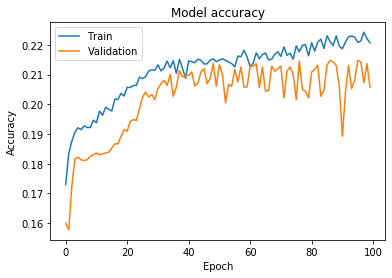

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

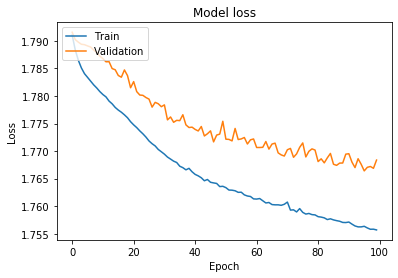

In [15]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
# Predict using X_test
y_pred = model.predict(X_test_nomood)

#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
    
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [17]:
# Accuracy score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 13.950850661625708


In [18]:
# true = y_test
# pred = y_pred
# last_value = X_bored_lastarray
same_correct = 0
same_wrong = 0
dif_correct = 0
dif_wrong = 0

X_test_mood = X_test_onlylastmood['cheerful_last'].values
for i in range(len(pred)):
    if (test[i] == X_test_mood[i]) and (test[i] == pred[i]):
        same_correct += 1
    if (test[i] == X_test_mood[i]) and (test[i] != pred[i]):
        same_wrong += 1
    if (test[i] != X_test_mood[i]) and (test[i] == pred[i]):
        dif_correct += 1
    if (test[i] != X_test_mood[i]) and (test[i] != pred[i]):
        dif_wrong += 1   

print("       ", "Same", "Dif")
print("correct", same_correct, dif_correct)
print("wrong  ", same_wrong, dif_wrong)

#Check if table is similar to accuracy
if (same_correct+dif_correct) / (same_correct+dif_correct+same_wrong+dif_wrong) == a:
    print("Table is right!")
else:
    print("Table is wrong")

        Same Dif
correct 235 134
wrong   1365 911
Table is right!


In [19]:
from collections import Counter
print("Predicted valxues: ", Counter(pred))
print("True values: ", Counter(test))
print("Previous mood:", Counter(X_test_mood))

Predicted valxues:  Counter({0: 1011, 5: 980, 1: 333, 3: 197, 4: 114, 2: 10})
True values:  Counter({3: 755, 2: 599, 4: 457, 1: 386, 0: 275, 5: 173})
Previous mood: Counter({3.0: 735, 2.0: 622, 4.0: 473, 1.0: 375, 0.0: 271, 5.0: 169})


In [20]:
same_correct_0, same_wrong_0, same_correct_1, same_wrong_1, same_correct_2, same_wrong_2, same_correct_3, same_wrong_3, same_correct_4, same_wrong_4, same_correct_5, same_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
dif_correct_0, dif_wrong_0, dif_correct_1, dif_wrong_1, dif_correct_2, dif_wrong_2, dif_correct_3, dif_wrong_3, dif_correct_4, dif_wrong_4, dif_correct_5, dif_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] == 0:
        if test[i] == X_test_mood[i]:
            same_correct_0 += 1
        if test[i] != X_test_mood[i]:
            dif_correct_0 += 1
    if test[i] == 0 and pred[i] != 0:
        if test[i] == X_test_mood[i]:
            same_wrong_0 += 1
        if test[i] != X_test_mood[i]:
            dif_wrong_0 += 1

    if test[i] == 1 and pred[i] == 1:
        if test[i] == X_test_mood[i]:
            same_correct_1 += 1
        if test[i] != X_test_mood[i]:
            dif_correct_1 += 1
    if test[i] == 1 and pred[i] != 1:
        if test[i] == X_test_mood[i]:
            same_wrong_1 += 1
        if test[i] != X_test_mood[i]:
            dif_wrong_1 += 1
        
    if test[i] == 2 and pred[i] == 2:
        if test[i] == X_test_mood[i]:
            same_correct_2 += 1
        if test[i] != X_test_mood[i]:
            dif_correct_2 += 1
    if test[i] == 2 and pred[i] != 2:
        if test[i] == X_test_mood[i]:
            same_wrong_2 += 1
        if test[i] != X_test_mood[i]:
            dif_wrong_2 += 1
    
    if test[i] == 3 and pred[i] == 3:
        if test[i] == X_test_mood[i]:
            same_correct_3 += 1
        if test[i] != X_test_mood[i]:
            dif_correct_3 += 1
    if test[i] == 3 and pred[i] != 3:
        if test[i] == X_test_mood[i]:
            same_wrong_3 += 1
        if test[i] != X_test_mood[i]:
            dif_wrong_3 += 1
        
    if test[i] == 4 and pred[i] == 4:
        if test[i] == X_test_mood[i]:
            same_correct_4 += 1
        if test[i] != X_test_mood[i]:
            dif_correct_4 += 1
    if test[i] == 4 and pred[i] != 4:
        if test[i] == X_test_mood[i]:
            same_wrong_4 += 1
        if test[i] != X_test_mood[i]:
            dif_wrong_4 += 1
    
    if test[i] == 5 and pred[i] == 5:
        if test[i] == X_test_mood[i]:
            same_correct_5 += 1
        if test[i] != X_test_mood[i]:
            dif_correct_5 += 1
    if test[i] == 5 and pred[i] != 5:
        if test[i] == X_test_mood[i]:
            same_wrong_5 += 1
        if test[i] != X_test_mood[i]:
            dif_wrong_5 += 1

print("Total length: ", len(X_test_mood))

print("Same Correct 0 guesses is: ", same_correct_0)
print("Same Wrong 0 guesses is: ", same_wrong_0)
print("Dif Correct 0 guesses is: ", dif_correct_0)
print("Dif Wrong 0 guesses is: ", dif_wrong_0)
print('')
print("Same Correct 1 guesses is: ", same_correct_1)
print("Same Wrong 1 guesses is: ", same_wrong_1)
print("Dif Correct 1 guesses is: ", dif_correct_1)
print("Dif Wrong 1 guesses is: ", dif_wrong_1)
print('')
print("Same Correct 2 guesses is: ", same_correct_2)
print("Same Wrong 2 guesses is: ", same_wrong_2)
print("Dif Correct 2 guesses is: ", dif_correct_2)
print("Dif Wrong 2 guesses is: ", dif_wrong_2)
print('')
print("Same Correct 3 guesses is: ", same_correct_3)
print("Same Wrong 3 guesses is: ", same_wrong_3)
print("Dif Correct 3 guesses is: ", dif_correct_3)
print("Dif Wrong 3 guesses is: ", dif_wrong_3)
print('')
print("Same Correct 4 guesses is: ", same_correct_4)
print("Same Wrong 4 guesses is: ", same_wrong_4)
print("Dif Correct 4 guesses is: ", dif_correct_4)
print("Dif Wrong 4 guesses is: ", dif_wrong_4)
print('')
print("Same Correct 5 guesses is: ", same_correct_5)
print("Same Wrong 5 guesses is: ", same_wrong_5)
print("Dif Correct 5 guesses is: ", dif_correct_5)
print("Dif Wrong 5 guesses is: ", dif_wrong_5)

Total length:  2645
Same Correct 0 guesses is:  103
Same Wrong 0 guesses is:  96
Dif Correct 0 guesses is:  34
Dif Wrong 0 guesses is:  42

Same Correct 1 guesses is:  27
Same Wrong 1 guesses is:  194
Dif Correct 1 guesses is:  32
Dif Wrong 1 guesses is:  133

Same Correct 2 guesses is:  1
Same Wrong 2 guesses is:  357
Dif Correct 2 guesses is:  1
Dif Wrong 2 guesses is:  240

Same Correct 3 guesses is:  35
Same Wrong 3 guesses is:  416
Dif Correct 3 guesses is:  27
Dif Wrong 3 guesses is:  277

Same Correct 4 guesses is:  10
Same Wrong 4 guesses is:  249
Dif Correct 4 guesses is:  15
Dif Wrong 4 guesses is:  183

Same Correct 5 guesses is:  59
Same Wrong 5 guesses is:  53
Dif Correct 5 guesses is:  25
Dif Wrong 5 guesses is:  36


In [21]:
mae_0, mae_1, mae_2, mae_3, mae_4, mae_5 = (0,0,0,0,0,0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] != 0:
        mae_0 += (abs(test[i]-pred[i]))
    if test[i] == 1 and pred[i] != 1:
        mae_1 += (abs(test[i]-pred[i]))
    if test[i] == 2 and pred[i] != 2:
        mae_2 += (abs(test[i]-pred[i]))
    if test[i] == 3 and pred[i] != 3:
        mae_3 += (abs(test[i]-pred[i]))
    if test[i] == 4 and pred[i] != 4:
        mae_4 += (abs(test[i]-pred[i]))
    if test[i] == 5 and pred[i] != 5:
        mae_5 += (abs(test[i]-pred[i]))

cnt_0, cnt_1, cnt_2, cnt_3, cnt_4, cnt_5 = (0,0,0,0,0,0)
for z in range(len(test)):
    if test[z] == 0:
        cnt_0 += 1
    if test[z] == 1:
        cnt_1 += 1
    if test[z] == 2:
        cnt_2 += 1
    if test[z] == 3:
        cnt_3 += 1
    if test[z] == 4:
        cnt_4 += 1
    if test[z] == 5:
        cnt_5 += 1

mae_macroaverage = ((mae_0/cnt_0) + (mae_1/cnt_1) + (mae_2/cnt_2) + (mae_3/cnt_3) + (mae_4/cnt_4) + (mae_5/cnt_5)) / 6

In [22]:
print("Macro-averaged Mean Absolute error is: ", round(mae_macroaverage, 4))
print("Macro-averaged F1-score is: ", round(f1_score(test, pred, average='weighted'), 4))

# print("Mean Squared error is: ", mean_squared_error(test, pred))
# print("Root Mean Squared error is: ", sqrt(mean_squared_error(test, pred)))

Macro-averaged Mean Absolute error is:  2.1242
Macro-averaged F1-score is:  0.1094
